In [1]:
# --- 1. Load and Prepare Data (EDA & Feature Engineering) ---
import pandas as pd 
import time
print("\n--- Step 1: Load and Prepare Data ---")
start_load_time = time.time()
data_path = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
try:
    # Load the data from the chosen path
    # low_memory=False is added to prevent dtype warnings with this large file
    df = pd.read_csv(data_path, low_memory=False) 
    
    print(f"Data loaded successfully in {time.time() - start_load_time:.2f} seconds.")
    print(f"Original dataset shape: {df.shape}")

    # --- FIX for new column names ---
    # We rename them to match the rest of our script's logic.
    if 'consumer_complaint_narrative' in df.columns:
        df = df.rename(columns={'consumer_complaint_narrative': 'Consumer complaint narrative'})
    if 'product' in df.columns:
         df = df.rename(columns={'product': 'Product'})
    # --- ADD THIS ---
    if 'issue' in df.columns:
         df = df.rename(columns={'issue': 'Issue'})
    # ----------------

except FileNotFoundError:
    print(f"Error: Could not find the file at {data_path}")
    print("Please check the 'input' folder name in your Kaggle sidebar and update the path.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check the path or your internet connection.")
    raise

# Define target categories from the project brief
target_categories = [
    'Credit reporting, repair, or other', 
    'Debt collection', 
    'Consumer Loan', 
    'Mortgage'
]



--- Step 1: Load and Prepare Data ---
Data loaded successfully in 130.76 seconds.
Original dataset shape: (11522175, 18)


In [2]:
df.shape

(11522175, 18)

In [3]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [4]:
df2 = df[['Product','Sub-product','Issue','Sub-issue','Consumer complaint narrative','Company response to consumer']]

In [5]:
Product_list = ['Credit reporting, credit repair services, or other personal consumer reports','Debt collection','Mortgage','Consumer Loan']

In [7]:
df2[df2['Product'].isin(Product_list)]['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Mortgage', 'Consumer Loan'], dtype=object)

In [8]:
df3 = df2[df2['Product'].isin(Product_list)]

In [13]:
df3.shape

(3521497, 6)

In [14]:
df3.isnull().sum()

Product                               0
Sub-product                           0
Issue                                 0
Sub-issue                        429655
Consumer complaint narrative    2198294
Company response to consumer          6
dtype: int64

In [15]:
df_clean = df3.dropna()

In [19]:
df_clean[df_clean['Product'].isin(Product_list)]['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Mortgage', 'Consumer Loan'], dtype=object)

In [18]:
cols_to_check = df3.columns.difference(['Sub-issue'])

df_clean = df3.dropna(subset=cols_to_check)

In [20]:
df_clean.shape

(1323200, 6)

<Axes: title={'center': 'Product Distribution'}, xlabel='Product'>

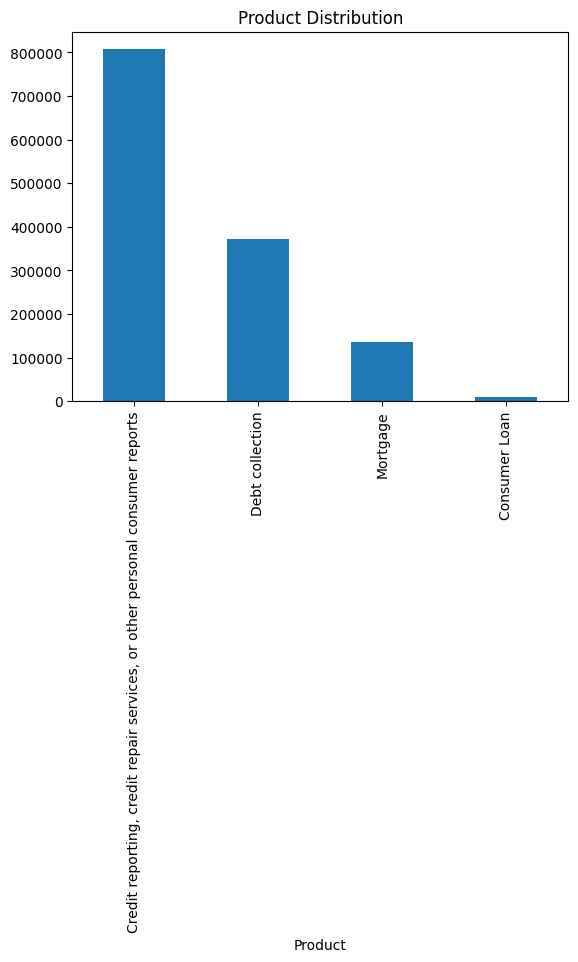

In [23]:
df_clean['Product'].value_counts().plot(kind='bar', title='Product Distribution')

In [24]:
# --- 2. Text Pre-Processing ---
print("\n--- Step 2: Text Pre-Processing ---")
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters, digits, and extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

print("🔄 Preprocessing text data...")
start_preprocess = time.time()

# Apply preprocessing to complaint narratives
df_clean['cleaned_text'] = df_clean['Consumer complaint narrative'].apply(preprocess_text)


--- Step 2: Text Pre-Processing ---


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔄 Preprocessing text data...


/tmp/ipykernel_202/3227019119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cleaned_text'] = df_clean['Consumer complaint narrative'].apply(preprocess_text)


In [25]:
initial_count = len(df_clean)
df_clean = df_clean[df_clean['cleaned_text'].str.len() > 50]
final_count = len(df_clean)

print(f"Removed {initial_count - final_count} rows with very short texts")
print(f"Final dataset shape after preprocessing: {df_clean.shape}")
print(f"Text preprocessing completed in {time.time() - start_preprocess:.2f} seconds")

# Check text length distribution
df_clean['text_length'] = df_clean['cleaned_text'].str.len()
print(f"\n📊 Text Length Statistics:")
print(f"Average length: {df_clean['text_length'].mean():.1f} characters")
print(f"Minimum length: {df_clean['text_length'].min():.1f} characters")
print(f"Maximum length: {df_clean['text_length'].max():.1f} characters")

# Display sample of cleaned text
print("\n📝 Sample of original vs cleaned text:")
for i in range(2):
    print(f"\nSample {i+1}:")
    print(f"Original: {df_clean['Consumer complaint narrative'].iloc[i][:100]}...")
    print(f"Cleaned:  {df_clean['cleaned_text'].iloc[i][:100]}...")

Removed 27155 rows with very short texts
Final dataset shape after preprocessing: (1296045, 7)
Text preprocessing completed in 539.53 seconds

📊 Text Length Statistics:
Average length: 652.1 characters
Minimum length: 51.0 characters
Maximum length: 24357.0 characters

📝 Sample of original vs cleaned text:

Sample 1:
Original: I wrote three requests, the unverified accounts listed below still remain on my credit report in vio...
Cleaned:  wrote three request unverified account listed still remain credit report violation federal law equif...

Sample 2:
Original: I paid off my Synchrony Lowes account. After this account was paid, Synchrony added a couple dollars...
Cleaned:  paid synchrony lowes account account paid synchrony added couple dollar interest made aware new char...


In [26]:
df_clean['Product'].value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    788668
Debt collection                                                                 363701
Mortgage                                                                        134342
Consumer Loan                                                                     9334
Name: count, dtype: int64

In [27]:
# Number of samples per category
sample_size = 9000

# Take stratified sample
df_sample = df_clean.groupby('Product').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)

# Check the resulting distribution
print(df_sample['Product'].value_counts())


Product
Consumer Loan                                                                   9000
Credit reporting, credit repair services, or other personal consumer reports    9000
Debt collection                                                                 9000
Mortgage                                                                        9000
Name: count, dtype: int64


/tmp/ipykernel_202/203206761.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_clean.groupby('Product').apply(lambda x: x.sample(n=sample_size, random_state=42)).reset_index(drop=True)


In [28]:
# --- 3. Feature Engineering ---
print("\n--- Step 3: Feature Engineering ---")
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Encode the target variable
print("🔤 Encoding target labels...")
label_encoder = LabelEncoder()
df_sample['category_encoded'] = label_encoder.fit_transform(df_sample['Product'])

print("Label encoding mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"  {i}: {category}")

# Create TF-IDF features
print("\n📝 Creating TF-IDF features...")
start_tfidf = time.time()

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limit features for efficiency
    ngram_range=(1, 2),     # Use unigrams and bigrams
    stop_words='english',
    min_df=5,               # Ignore terms that appear in less than 5 documents
    max_df=0.7,             # Ignore terms that appear in more than 70% of documents
    sublinear_tf=True       # Use sublinear term frequency scaling
)

X = tfidf_vectorizer.fit_transform(df_sample['cleaned_text'])
y = df_sample['category_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"TF-IDF vectorization completed in {time.time() - start_tfidf:.2f} seconds")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution in splits
)

print(f"\n📊 Data Split:")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Check class distribution in splits
print("\nClass distribution:")
print("Training set:", pd.Series(y_train).value_counts().sort_index().tolist())
print("Testing set: ", pd.Series(y_test).value_counts().sort_index().tolist())


--- Step 3: Feature Engineering ---
🔤 Encoding target labels...
Label encoding mapping:
  0: Consumer Loan
  1: Credit reporting, credit repair services, or other personal consumer reports
  2: Debt collection
  3: Mortgage

📝 Creating TF-IDF features...
Feature matrix shape: (36000, 5000)
TF-IDF vectorization completed in 8.00 seconds

📊 Data Split:
Training set: (28800, 5000)
Testing set: (7200, 5000)

Class distribution:
Training set: [7200, 7200, 7200, 7200]
Testing set:  [1800, 1800, 1800, 1800]


In [29]:
# --- 4. Selection of Multi Classification Model & Training ---
print("\n--- Step 4: Model Training ---")
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    'XGBoost': XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
}

# Train and evaluate models
results = {}
training_times = {}
predictions = {}

print("🤖 Training multiple models...")
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    start_time = time.time()
    
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        training_time = time.time() - start_time
        results[name] = accuracy
        training_times[name] = training_time
        predictions[name] = y_pred
        
        print(f"   ✅ {name} Accuracy: {accuracy:.4f}")
        print(f"   ⏱️  Training time: {training_time:.2f} seconds")
        
    except Exception as e:
        print(f"   ❌ {name} failed: {e}")
        results[name] = 0
        training_times[name] = 0

# Save all trained models
for name, model in models.items():
    if name in results and results[name] > 0:  # Only save if model was trained successfully
        joblib.dump(model, f'{name.replace(" ", "_").lower()}.pkl')
        print(f"💾 {name} saved successfully")

print("✓ All models trained and saved")


--- Step 4: Model Training ---
🤖 Training multiple models...

🔧 Training Logistic Regression...
   ✅ Logistic Regression Accuracy: 0.8764
   ⏱️  Training time: 5.09 seconds

🔧 Training Multinomial NB...
   ✅ Multinomial NB Accuracy: 0.8354
   ⏱️  Training time: 0.02 seconds

🔧 Training Linear SVC...
   ✅ Linear SVC Accuracy: 0.8706
   ⏱️  Training time: 0.74 seconds

🔧 Training Random Forest...
   ✅ Random Forest Accuracy: 0.8557
   ⏱️  Training time: 22.79 seconds

🔧 Training XGBoost...
   ✅ XGBoost Accuracy: 0.8556
   ⏱️  Training time: 140.95 seconds
💾 Logistic Regression saved successfully
💾 Multinomial NB saved successfully
💾 Linear SVC saved successfully
💾 Random Forest saved successfully
💾 XGBoost saved successfully
✓ All models trained and saved



--- Step 5: Model Comparison ---
📊 Model Performance Ranking:
              Model  Accuracy  Training_Time
Logistic Regression  0.876389       5.094951
         Linear SVC  0.870556       0.735701
      Random Forest  0.855694      22.785656
            XGBoost  0.855556     140.946044
     Multinomial NB  0.835417       0.018730


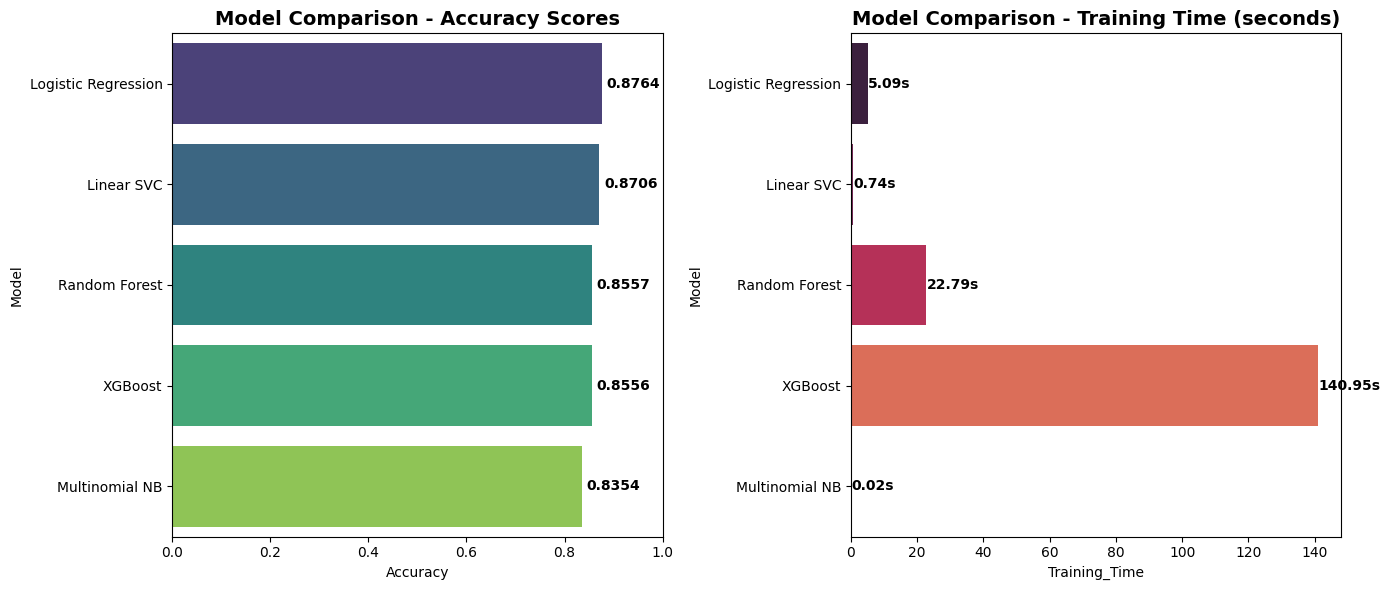


🏆 Best Performing Model: Logistic Regression
🎯 Best Accuracy: 0.8764


In [30]:
# --- 5. Comparison of Model Performance ---
print("\n--- Step 5: Model Comparison ---")
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values()),
    'Training_Time': [training_times.get(model, 0) for model in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("📊 Model Performance Ranking:")
print(results_df.to_string(index=False))

# Visualization 1: Accuracy Comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Comparison - Accuracy Scores', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# Visualization 2: Training Time Comparison
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Training_Time', y='Model', palette='rocket')
plt.title('Model Comparison - Training Time (seconds)', fontsize=14, fontweight='bold')
for i, v in enumerate(results_df['Training_Time']):
    plt.text(v + 0.1, i, f'{v:.2f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_accuracy = results_df.iloc[0]['Accuracy']
print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"🎯 Best Accuracy: {best_accuracy:.4f}")


--- Step 6: Model Evaluation ---
📋 Detailed Evaluation for Logistic Regression:

CLASSIFICATION REPORT:
                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.87      0.89      0.88      1800
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.85      0.85      1800
                                                             Debt collection       0.84      0.82      0.83      1800
                                                                    Mortgage       0.95      0.94      0.94      1800

                                                                    accuracy                           0.88      7200
                                                                   macro avg       0.88      0.88      0.88      7200
                                                                wei

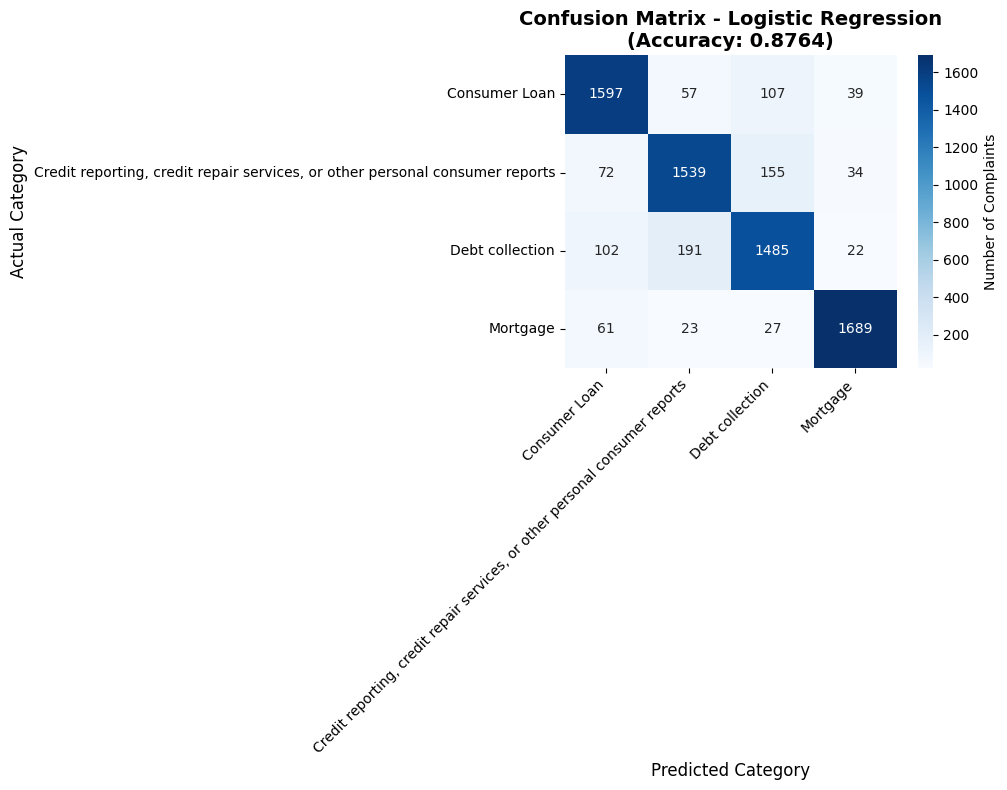


DETAILED METRICS BY CLASS:
                                               Class  Precision  Recall  \
0                                      Consumer Loan     0.8717  0.8872   
1  Credit reporting, credit repair services, or o...     0.8503  0.8550   
2                                    Debt collection     0.8371  0.8250   
3                                           Mortgage     0.9467  0.9383   

   F1-Score  Support  
0    0.8794     1800  
1    0.8526     1800  
2    0.8310     1800  
3    0.9425     1800  

TOP FEATURES BY CATEGORY:

📊 Top 10 features for 'Consumer Loan':
    1. loan                 : 6.3833
    2. car                  : 5.8513
    3. vehicle              : 4.9804
    4. finance              : 4.2954
    5. financial            : 4.0378
    6. ally                 : 3.6973
    7. santander            : 3.3885
    8. auto                 : 3.2624
    9. xxxxxxxxxxxx         : 2.9563
   10. dealer               : 2.8311

📊 Top 10 features for 'Credit reporting, cr

In [31]:
# --- 6. Model Evaluation ---
print("\n--- Step 6: Model Evaluation ---")

# Detailed evaluation of best model
print(f"📋 Detailed Evaluation for {best_model_name}:")
y_pred_best = predictions[best_model_name]

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Number of Complaints'})
plt.title(f'Confusion Matrix - {best_model_name}\n(Accuracy: {best_accuracy:.4f})', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual Category', fontsize=12)
plt.xlabel('Predicted Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate precision, recall, f1-score for each class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_best, average=None)

print("\n" + "="*60)
print("DETAILED METRICS BY CLASS:")
print("="*60)
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(metrics_df.round(4))

# Feature Importance (for interpretable models)
if hasattr(best_model, 'coef_'):
    print("\n" + "="*60)
    print("TOP FEATURES BY CATEGORY:")
    print("="*60)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"\n📊 Top 10 features for '{class_name}':")
        coef = best_model.coef_[i]
        top_indices = coef.argsort()[-10:][::-1]
        top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]
        for j, (feature, score) in enumerate(top_features, 1):
            print(f"   {j:2d}. {feature:20s} : {score:.4f}")

elif hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*60)
    print("TOP OVERALL FEATURES:")
    print("="*60)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = best_model.feature_importances_
    top_indices = importances.argsort()[-20:][::-1]
    top_features = [(feature_names[idx], importances[idx]) for idx in top_indices]
    for j, (feature, importance) in enumerate(top_features, 1):
        print(f"   {j:2d}. {feature:20s} : {importance:.4f}")

In [32]:
# --- 8. Prediction System ---
print("\n--- Step 8: Prediction System ---")

def predict_complaint(text, model=best_model, vectorizer=tfidf_vectorizer, encoder=label_encoder):
    """
    Predict the category of a new complaint text
    """
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    
    # Transform using TF-IDF
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction = model.predict(text_tfidf)[0]
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
    else:
        # For models without probability, create dummy probabilities
        probabilities = [0] * len(encoder.classes_)
        probabilities[prediction] = 1.0
    
    # Get results
    predicted_category = encoder.inverse_transform([prediction])[0]
    
    print(f"📝 Input Text: {text[:200]}..." if len(text) > 200 else f"📝 Input Text: {text}")
    print(f"🎯 Predicted Category: {predicted_category}")
    
    print("📊 Probability Distribution:")
    prob_df = pd.DataFrame({
        'Category': encoder.classes_,
        'Probability': probabilities
    }).sort_values('Probability', ascending=False)
    
    for _, row in prob_df.iterrows():
        print(f"   {row['Category']:50s} : {row['Probability']:.4f}")
    
    return predicted_category, probabilities

# Test predictions with sample complaints
print("🧪 Testing Prediction System with Sample Complaints:")
print("="*70)

sample_complaints = [
    "I have been trying to dispute errors on my credit report for months but the credit bureau is not responding to my requests. They keep asking for the same documents repeatedly.",
    "A debt collector has been calling me constantly about a debt that I don't even recognize. They call early morning and late night using threatening language and harassing my family members.",
    "My mortgage company applied my payment incorrectly and then charged me late fees unfairly. When I called to explain, they were rude and refused to correct their mistake.",
    "I applied for a personal consumer loan and was approved but the interest rate was much higher than advertised with hidden fees that weren't disclosed during the application process.",
    "There are multiple accounts on my credit report that don't belong to me. I've filed disputes with all three credit bureaus multiple times but they keep verifying inaccurate information."
]

for i, complaint in enumerate(sample_complaints, 1):
    print(f"\n🔍 Test Case {i}:")
    print("-" * 50)
    predicted, probs = predict_complaint(complaint)
    print("-" * 50)

# Batch prediction function
def predict_multiple_complaints(complaints_list):
    """Predict categories for multiple complaints at once"""
    print(f"\n📦 Batch Prediction for {len(complaints_list)} complaints:")
    print("="*60)
    
    results = []
    for i, complaint in enumerate(complaints_list, 1):
        cleaned_text = preprocess_text(complaint)
        text_tfidf = tfidf_vectorizer.transform([cleaned_text])
        prediction = best_model.predict(text_tfidf)[0]
        predicted_category = label_encoder.inverse_transform([prediction])[0]
        
        if hasattr(best_model, 'predict_proba'):
            probability = best_model.predict_proba(text_tfidf)[0][prediction]
        else:
            probability = 1.0
            
        results.append({
            'Complaint_ID': i,
            'Predicted_Category': predicted_category,
            'Confidence': probability
        })
        
        print(f"{i:2d}. {predicted_category:50s} (Confidence: {probability:.4f})")
    
    return results

# Test batch prediction
print("\n🧪 Testing Batch Prediction:")
batch_results = predict_multiple_complaints(sample_complaints)


--- Step 8: Prediction System ---
🧪 Testing Prediction System with Sample Complaints:

🔍 Test Case 1:
--------------------------------------------------
📝 Input Text: I have been trying to dispute errors on my credit report for months but the credit bureau is not responding to my requests. They keep asking for the same documents repeatedly.
🎯 Predicted Category: Credit reporting, credit repair services, or other personal consumer reports
📊 Probability Distribution:
   Credit reporting, credit repair services, or other personal consumer reports : 0.6681
   Debt collection                                    : 0.1682
   Consumer Loan                                      : 0.1257
   Mortgage                                           : 0.0380
--------------------------------------------------

🔍 Test Case 2:
--------------------------------------------------
📝 Input Text: A debt collector has been calling me constantly about a debt that I don't even recognize. They call early morning and l